# Exploring Catalog-based Evaluations

Author: William Savran  
Date: 05 May 2020

The catalog-based evaluations outlined in Savran et al., 2020 provide likelihood-free counterparts to the Poisson-based evaluations designed for gridded forecasts (e.g., Schorlemmer et al., 2007; Zechar et al., 2010). In this notebook, I investigate the behavior of these likelihood-free evaluations in the context of their Poissonian counterparts. This analysis will help to illuminate the differences between these approaches, and potentially identify short-comings of the new evaluations.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle raw code"></form>''')



## Introduction

The following numerical experiments use simulations on spatially uniform (SU) forecasts to explore the behavior of the statistics proposed in Savran et al., 2020. The equation for the test statistic is as follows,

\begin{equation}
S = \left [ \sum_{i=1}^{N} \log{\hat{\lambda}(k_i)} \right ] N^{-1}.
\end{equation}

Here $\hat{\lambda}$ is the approximate rate-density provided estimated as the expected event-count per spatial cell from the forecast and $N$ represents the number of target events, and $k_i$ indicates the cell index, $k$, of the $i^{th}$ event. The statistic $S$ can be regarded as the geometric mean of the target event rate distribution.

In additon to the SU forecasts, I use two forecasts from UCERF3-ETAS and UCERF3-NoFaults starting after the M 7.1 Ridgecrest mainshock to explore the catalog-based spatial-test. These forecasts are located on `opensha [dot] usc [dot] edu` at the path defined in the code cell below. The analysis uses the PyCSEP toolkit available on [GitHub](https://github.com/SCECcode/csep2/).

In [2]:
# Python Imports
import os
import json
import time
import itertools
import datetime

# Third-party Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as nd

# PyCSEP imports
from csep import load_stochastic_event_sets
from csep.core.forecasts import GriddedDataSet
from csep.core.evaluations import EvaluationResult
from csep.core.csep1_tests import csep1_spatial_test
from csep.core.repositories import FileSystem
from csep.core.catalogs import ComcatCatalog
from csep.core.analysis import ApproximateSpatialRateDensity
from csep.utils.spatial import CartesianGrid2D, california_relm_region, masked_region
from csep.utils.stats import ecdf
from csep.utils.comcat import get_event_by_id
from csep.utils.scaling_relationships import WellsAndCoppersmith
from csep.utils.basic_types import Polygon
from csep.utils.time_utils import datetime_to_utc_epoch
from csep.utils.constants import SECONDS_PER_ASTRONOMICAL_YEAR, CSEP_MW_BINS

In [3]:
# random seed for reproducibility
seed=1234567
np.random.seed(seed)

In [99]:
class MockCatalog:
    """ Creates a mock object that can be used to call csep1_tests directly. """
    def __init__(self, data, name=''):
        self.data = data
        self.name = name
        
    def spatial_counts(self):
        return self.data

def create_uniform_spatial_forecast(constant_rate, region, name=''):
    """ Create uniform spatial forecast for evaluation purposes
    
    Args:
        constant_rate (float): value of homogeneous poisson point-process
        region (csep.utils.spatial.Region): region of uniform forecast
        name (str): used to label the forecast for plotting 
        
    Returns:
        forecast (csep.core.forecasts.GriddedDataSet): spatial forecast
    """
    # this will throw error if it cannot be made into numpy array
    rate = np.array(constant_rate)
    if not isinstance(region, CartesianGrid2D):
        raise TypeError("region should be CartesianGrid2D")
    
    # this will throw and error if constant_rate is not a scalar or list-like with 
    data = np.ones(region.num_nodes) * constant_rate
    spatial_forecast = GriddedDataSet(data, region, name)
    return spatial_forecast

def simulate_catalog(forecast, n_target_events, force_unity=False):
    n_bins = forecast.region.num_nodes
    obs_cat = np.zeros(n_bins)
    rand_event_locs = np.random.randint(n_bins, size=int(n_target_events))
    if force_unity:
        rand_event_locs = list(set(rand_event_locs))
    np.add.at(obs_cat, rand_event_locs, 1)
    cat = MockCatalog(obs_cat)
    return cat

def spatial_test_statistic_no_normalization(gridded_forecast_rates, target_counts):
    """ implemented following Eq. 18 in BSSA manuscript"""
    
    n_target = np.sum(target_counts)
    log_rates = np.log10(gridded_forecast_rates)
    # we still compute the mean here
    statistic = np.sum(target_counts*log_rates) / n_target
    return statistic
    
def spatial_test_statistic_normalization(gridded_forecast_rates, target_counts):
    """ implemented following Eq. 18 in BSSA manuscript"""
    idx = target_counts != 0
    n_target = np.sum(target_counts)
    # normalize so rates sum to unity
    normed_rates = gridded_forecast_rates / np.sum(gridded_forecast_rates)
    log_rates = np.log10(normed_rates)
    # we still compute the mean here
    statistic = np.sum(target_counts[idx]*log_rates[idx]) / n_target
    return statistic

def approximate_likelihood_statistic_normalization(gridded_forecast_rates, target_counts):
    """ implemented following Eq. 18 in BSSA manuscript, will only throw warning if target event occurs where 0 in forecast."""
    n_target = np.sum(target_counts)
    # normalize so rates sum to unity
    normed_rates = gridded_forecast_rates / np.sum(gridded_forecast_rates)
    idx = target_counts != 0
    log_rates = np.log10(normed_rates[idx])
    # we still compute the mean here
    statistic = np.sum(target_counts[idx]*log_rates)
    return statistic

def csep2_spatial_test(forecast, observed_catalog, num_simulations=10000, fix_simulated_events=True,
                       func=spatial_test_statistic_normalization, condition_on_nobs=False, verbose=True):
    """
    Performs the Spatial Test on the Forecast using the Observed Catalogs.

    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.

    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score, 
                               only used when need to simulate catalogs
        fix_simulated_events (bool): whether we should condition on the number of simualted events
        func: reference to func used to compute spatial test statistic,
        condition_on_nobs (bool): if true and forecast is provided, 

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """
    # grid catalog onto spatial grid
    gridded_catalog_data = observed_catalog.spatial_counts()
    n_obs = np.sum(gridded_catalog_data)
    n_fore = np.sum(forecast.spatial_counts())
    tol = 0.05
    
    # does the forecast provide simulations, and could remove if/else by adding .catalogs() routine to forecast
    # need to think about if this is actually necessary and worthwhile before implementing in the actual code-base
    # pros, adds consistency between types of forecasts by being able to iterate over simulations, 
    # cons: gridded forecast simulations will also be on a grid whereas the catalog forecast simulations are catalogs
    t0 = time.time()
    if hasattr(forecast, 'catalogs'):
        print(f"Using catalogs generated by {forecast.name} for evaluation.")
        test_distribution = []
        num_simulations = forecast.n_cat
        for idx, target_catalog in enumerate(forecast.catalogs):
            if verbose:
                tens_exp = np.floor(np.log10(idx + 1))
                if (idx + 1) % 10 ** tens_exp == 0:
                    t1 = time.time()
                    print(f'Processed {idx+1} catalogs in {t1-t0} seconds', flush=True)
            # add to test distribution 
            if condition_on_nobs:
                if target_catalog.event_count >= n_obs * (1-tol) and target_catalog.event_count < n_obs * (1+tol):
                    test_distribution.append(func(forecast.spatial_counts(), target_catalog.spatial_counts()))
            else:
                test_distribution.append(func(forecast.spatial_counts(), target_catalog.spatial_counts()))
            
    # simulations assume spatially uniform poisson forecasts
    else:
        test_distribution = np.empty(num_simulations)
        for idx in range(num_simulations):
            if fix_simulated_events == True:
                n_sim = n_obs
            else:
                n_sim = int(np.random.poisson(n_fore))
            # simulate target catalog
            target_catalog = simulate_catalog(forecast, n_sim)
            test_distribution[idx] = func(forecast.spatial_counts(), target_catalog.spatial_counts())
    
    # compute observed statistic
    observed_statistic = func(forecast.spatial_counts(), gridded_catalog_data)
    
    # compute quantile score
    qs = np.sum(test_distribution <= observed_statistic) / num_simulations

    # populate result data structure
    result = EvaluationResult()
    result.test_distribution = test_distribution
    result.name = 'CSEP2 S-Test'
    result.observed_statistic = observed_statistic
    result.quantile = qs
    result.sim_name = forecast.name
    result.obs_name = observed_catalog.name
    result.status = 'normal'
    result.min_mw = -1
    return result

## Understanding the Spatial Test using Spatially Uniform Forecasts

**Summary:**
1. Normalizing $\lambda$ only becomes important if one is interested in comparing observed statistics between two forecasts. Without normalization the statistic differs by $\log(K)$ where $K$ is the ratio of expected event counts between the two forecasts.<br>

2. For SU forecasts, the test distribution of $S$ is, by definition, not influenced by variability in the forecasted number distribution. 

3. Implied, but not confirmed from the SU tests: The estimate of $S$ will be influenced by the both sampling distribution and the distribution of $\hat{\lambda}$. The former is how we are probing the 'spatial distribution' of the forecast.

3. The CSEP1 metric has non-zero variance in the test-distribution even when the observed event set is generated from the same distribution as the forecast. This results from multiple events occurring in a spatial bin. 

4. The geometric mean and the sum of the target event rate distribution (spatial Pseudo-LL) produce equivalent quantile scores for SU forecasts when conditioned on the number of observed events.

5. The test distribution of the spatial Pseudo-LL scores reflects the number distribution of the forecast in addition to the sampling distribution and the distribution of $\hat{\lambda}$.

### Normalization of Approximated Rate Density for Spatial Test

This comparison looks at why we should be normalizing the approximate rate-density from the forecast. The basic concern is that if two forecasts A and B have log-rates specified where $\log(A) > \log(B)$, then an observed test statistic will not be equivalent when calculated for forecasts $A$ and $B$. We expect this statistic to differ by $\log(K)$ where $K$ is the ratio $A/B$.

Testing Without Normalization of Forecasted Rates
Forecast A (not normalized): -1.0
Forecast B (not normalized): -0.6989700043360187
Log10(K): 0.3010299956639812 StatA - StatB: 0.30102999566398125

Testing With Normalization of Forecasted Rates
Forecast A (normalized): -2.0
Forecast B (normalized): -2.0

Quantile Score (ForecastA): 1.0
Quantile Score (ForecastB): 1.0


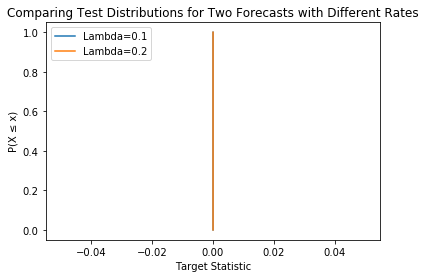

In [5]:
# create dummy region for forecast with origins spanning from 0-9 in both dimensions
origins = np.array(list(itertools.product(np.arange(10), np.arange(10))))
region = CartesianGrid2D.from_origins(origins)

rateA = 0.1
rateB = 0.2

# create uniform spatial forecast
forecastA = create_uniform_spatial_forecast(rateA, region, name=f'Lambda={rateA}')
forecastB = create_uniform_spatial_forecast(rateB, region, name=f'Lambda={rateB}')

# create fake catalog observations, simply as numpy array of counts in cells
n_obs = int(rateA * forecastA.region.num_nodes)
obs_cat = simulate_catalog(forecastA, n_obs)

# compute likelihood with normalization
spatial_stat_no_normA = spatial_test_statistic_no_normalization(forecastA.data, obs_cat.data)
spatial_stat_no_normB = spatial_test_statistic_no_normalization(forecastB.data, obs_cat.data)

# compute likelihood without normalization
spatial_stat_normA = spatial_test_statistic_normalization(forecastA.data, obs_cat.data)
spatial_stat_normB = spatial_test_statistic_normalization(forecastB.data, obs_cat.data)

print("Testing Without Normalization of Forecasted Rates")
print(f"Forecast A (not normalized): {spatial_stat_no_normA}\nForecast B (not normalized): {spatial_stat_no_normB}")
print(f"Log10(K): {np.log10(rateB / rateA)} StatA - StatB: {spatial_stat_no_normB-spatial_stat_no_normA}")
np.testing.assert_allclose(np.log10(rateB/rateA), spatial_stat_no_normB-spatial_stat_no_normA)
print()
print("Testing With Normalization of Forecasted Rates")
print(f"Forecast A (normalized): {spatial_stat_normA}\nForecast B (normalized): {spatial_stat_normB}")
np.testing.assert_allclose(spatial_stat_normA, spatial_stat_normB)

resultA = csep2_spatial_test(forecastA, obs_cat, func=spatial_test_statistic_no_normalization)
resultB = csep2_spatial_test(forecastB, obs_cat, func=spatial_test_statistic_no_normalization)

xA, yA = ecdf(resultA.test_distribution-resultA.observed_statistic)
xB, yB = ecdf(resultB.test_distribution-resultB.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xA, yA, label=f'{forecastA.name}')
h=ax.plot(xB, yB, label=f'{forecastB.name}')
h=ax.legend(loc='upper left')
h=ax.set_title('Comparing Test Distributions for Two Forecasts with Different Rates')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')
print()
print(f'Quantile Score (ForecastA): {resultA.quantile}\nQuantile Score (ForecastB): {resultB.quantile}')

This numerical experiment shows the necessity of normalizing $\lambda$ in order to compare observed spatial statistics across forecasts. In practice, we are mostly concerned with quantile scores which are unaffected by this normalization. As expected, the difference in the test statistic between the two forecasts is $\log(K)$ where $K$ is the ratio of the forecasted rates.

### Conditioning on the Number of Observed Events for Spatial Test

The proposed statistic represents the geometric mean of the target event rate distribution, therefore not conditioning the simulated number of target events on the observed event counts will produce statistics with different levels of precision. Here, we explore this using the spatially uniform (SU) forecasts from above. We label the distribution 'fixed' if the statistics are computed conditioned on the number of observed events, and 'not fixed' otherwise.

We use two tests that generate families of test statistics through simulation. (1) we condition the number of simulated events on the number of observed events, and (2) we do not condition the number of simulated events on the number of observed events. We will compare quantile scores and variance of the test statistics between these two experiments.

For a spatially uniform forecast (SU), these proposed test statistic should have zero variance with all values being equal to the normalized statistic shown above.

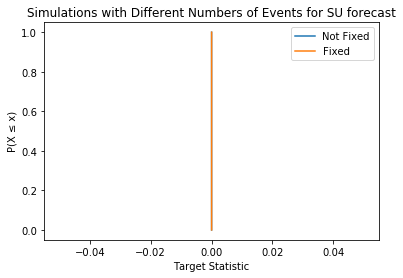

In [6]:
result_fixed = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=True)
result_not_fixed = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=False)

xF, yF = ecdf(result_fixed.test_distribution-result_fixed.observed_statistic)
xNF, yNF = ecdf(result_not_fixed.test_distribution-result_not_fixed.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xNF, yNF, label='Not Fixed')
h=ax.plot(xF, yF, label='Fixed')
h=ax.legend(loc='upper right')
h=ax.set_title('Simulations with Different Numbers of Events for SU forecast')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')

For a SU forecast, conditioning on $N_{obs}$ does not impact the estimate of the test statistic. This behavior should be re-evaluated in the context of a realistic forecast that incorporates spatial variability into the forecast. These results imply that the estimated error of the simulated test statistic is related to the variance of the spatial distribution of the forecast.

### Comparing Poisson and Likelihood-Free Evaluations with Poissonian (CSEP1) Counterparts



The CSEP1 Spatial test is based on Poisson log-likelihood function is defined as, 

\begin{equation}
L(\lambda, \omega) = \omega \log\lambda - \lambda - \log(\omega!).
\end{equation}

Where $\lambda$ represents the expected rates in discrete spatial bins as specified by a forecast and $\omega$ represents observed event counts in the same discrete spatial bins. The $\lambda$ is normalized so its sum equals the number of observed events and events are simulated based on the forecast following Zechar et al., (2010). This statistic represents a joint log-likelihood of $\lambda$ and $\omega$. On the other hand, the CSEP2 spatial-test computes the geometric mean of the target event rate distribution defined as $S$ above. 


Quantile Score (CSEP1): 0.328
Quantile Score (CSEP1): 0.328
Quantile Score (CSEP2): 1.0


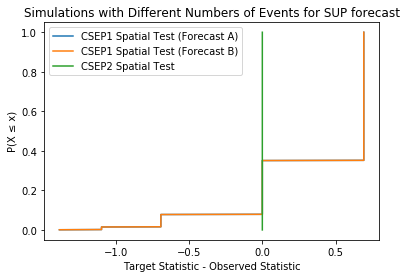

In [7]:
# needed for CSEP1, dummy values and this should chagne in PyCSEP
forecastA.magnitudes = np.arange(10)
forecastB.magnitudes = np.arange(10)
n_sim=1000

# generate random numbers so forecastA == forecastB
random_numbers = np.random.rand(n_sim,n_obs)

csep1_result = csep1_spatial_test(forecastA, obs_cat, verbose=False, random_numbers=random_numbers, num_simulations=n_sim)
csep1_resultB = csep1_spatial_test(forecastB, obs_cat, verbose=False, random_numbers=random_numbers, num_simulations=n_sim)
xC1, yC1 = ecdf(csep1_result.test_distribution-csep1_result.observed_statistic)
xC1B, yC1B = ecdf(csep1_resultB.test_distribution-csep1_result.observed_statistic)
fig, ax = plt.subplots()
h=ax.plot(xC1, yC1, label='CSEP1 Spatial Test (Forecast A)')
h=ax.plot(xC1B, yC1B, label='CSEP1 Spatial Test (Forecast B)')
h=ax.plot(xF, yF, label='CSEP2 Spatial Test')
h=ax.legend(loc='upper left')
h=ax.set_title('Simulations with Different Numbers of Events for SUP forecast')
h=ax.set_xlabel('Target Statistic - Observed Statistic')
h=ax.set_ylabel('P(X ≤ x)')
print()
print(f'Quantile Score (CSEP1): {csep1_result.quantile}\nQuantile Score (CSEP1): {csep1_resultB.quantile}\n' + 
      f'Quantile Score (CSEP2): {result_fixed.quantile}')

The simulated distributions of the test statistics vary between the CSEP1 and CSEP2 implementations of the spatial test, as expected by the differing test statistics. Namely, the CSEP1 test assumes a Poisson distribution for the individual cells which includes additional terms resulting from the discrete assumptions with the Poisson distribution (Rhoades et al., 2011).

The primary difference of these two tests is that the quantile score and test distribution is invariant with the number of simulations assuming a spatially uniform forecast. The CSEP1 metric introduces Poissonian variability and fluctuates both test distribution and quantile score depending on both the observed catalog and simulated likelihood scores.

### Using an approximate Likelihood Statistic instead of Geometric Mean

The proposed metric uses the geometric mean of the target event rate distribution which has the desirable property that two catalogs with identical spatial distributions and different rates will produce identical statistics. We will condition this test on the number of observed events.


Quantile Score (CSEP1): 0.338
Quantile Score (CSEP2 Apprx. LL): 1.0
Quantile Score (CSEP2 Geo. Mean): 1.0
Geo. Mean: -2.0
Apprx. LogLL: -20.0


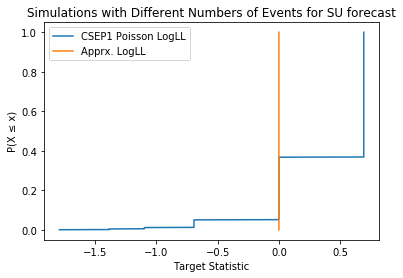

In [8]:
result_fixed_no_mean = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=True, 
                                  func=approximate_likelihood_statistic_normalization)
csep1_result = csep1_spatial_test(forecastA, obs_cat, verbose=False)

xC1, yC1 = ecdf(csep1_result.test_distribution-csep1_result.observed_statistic)
xF_noMean, yF_noMean = ecdf(result_fixed_no_mean.test_distribution - result_fixed_no_mean.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xC1, yC1, label='CSEP1 Poisson LogLL')
h=ax.plot(xF_noMean, yF_noMean, label='Apprx. LogLL')
h=ax.legend(loc='upper left')
h=ax.set_title('Simulations with Different Numbers of Events for SU forecast')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')
print()
print(f'Quantile Score (CSEP1): {csep1_result.quantile}\nQuantile Score (CSEP2 Apprx. LL): {result_fixed_no_mean.quantile}\n' +
      f'Quantile Score (CSEP2 Geo. Mean): {result_fixed.quantile}')
print(f'Geo. Mean: {result_fixed.observed_statistic}\nApprx. LogLL: {result_fixed_no_mean.observed_statistic}')

As expected, this modification only changes the value of the observed statistic, but not the overall shape of the simulated test distribution. The geometric mean and approximate log-liklihood are only consistent when we fix the number of simulated events to the number of observed events. 

### Approx. Likelihood Statistic with and without Conditioning Simulations on Number of Observed Events

The CSEP2 implementation of the spatial test statistic computes a geometric mean, which negates the impact of the event count in a catalog. Here, we explore how the test distribution looks when calculated as the sum over the log-target event rate distribution as proposed in original document of catalog-based tests.

Quantile Score (CSEP1): 0.32
Quantile Score (CSEP2 Apprx. CondLL; ForecastA): 1.0
Quantile Score (CSEP2 Apprx. LL; ForecastA): 0.5402
Quantile Score (CSEP2 Apprx. LL; ForecastB): 0.9945


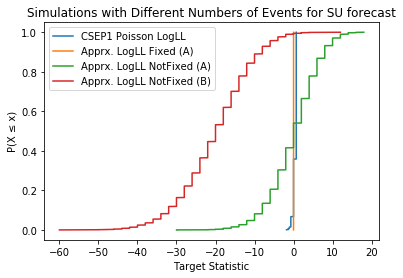

In [9]:
result_fixed_no_mean = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=True, 
                                  func=approximate_likelihood_statistic_normalization)

result_fixed_no_meanB = csep2_spatial_test(forecastB, obs_cat, fix_simulated_events=True, 
                                  func=approximate_likelihood_statistic_normalization)

# in this case rateA = rate(obs_cat)
result_notfixed_no_mean = csep2_spatial_test(forecastA, obs_cat, fix_simulated_events=False, 
                                  func=approximate_likelihood_statistic_normalization)

# in this case rateB != rate(obs_cat)
result_notfixed_no_meanB = csep2_spatial_test(forecastB, obs_cat, fix_simulated_events=False, 
                                  func=approximate_likelihood_statistic_normalization)

csep1_result = csep1_spatial_test(forecastA, obs_cat, verbose=False)
xC1, yC1 = ecdf(csep1_result.test_distribution-csep1_result.observed_statistic)

xF_noMean, yF_noMean = ecdf(result_fixed_no_mean.test_distribution - result_fixed_no_mean.observed_statistic)
xNF_noMean, yNF_noMean = ecdf(result_notfixed_no_mean.test_distribution - result_notfixed_no_mean.observed_statistic)
xNF_noMeanB, yNF_noMeanB = ecdf(result_notfixed_no_meanB.test_distribution - result_notfixed_no_meanB.observed_statistic)

fig, ax = plt.subplots()
h=ax.plot(xC1, yC1, label='CSEP1 Poisson LogLL')
h=ax.plot(xF_noMean, yF_noMean, label='Apprx. LogLL Fixed (A)')
h=ax.plot(xNF_noMean, yNF_noMean, label='Apprx. LogLL NotFixed (A)')
h=ax.plot(xNF_noMeanB, yNF_noMeanB, label='Apprx. LogLL NotFixed (B)')
h=ax.legend(loc='upper left')
h=ax.set_title('Simulations with Different Numbers of Events for SU forecast')
h=ax.set_xlabel('Target Statistic')
h=ax.set_ylabel('P(X ≤ x)')

print(f'Quantile Score (CSEP1): {csep1_result.quantile}\nQuantile Score (CSEP2 Apprx. CondLL; ForecastA): {result_fixed.quantile}\n' +
      f'Quantile Score (CSEP2 Apprx. LL; ForecastA): {result_notfixed_no_mean.quantile}\nQuantile Score (CSEP2 Apprx. LL; ForecastB): {result_notfixed_no_meanB.quantile}')

The above figure shows four different cases for computing a spatial-test for a SU forecast with associated quantile scores. The blue line denotes the CSEP1 approach that uses a Poisson log-likelihood function. The orange line uses the proposed approach based on the geometric mean of the target event rate distribution. The green line sums builds event rates by summing over the log(event rates) and assuming some non-zero variance in the forecasted number distribution. The expected rate of ForecastA equals the observed number of events. The red line shows the same calculation as prior, but using a forecast, called $B$, that overpredicts the number of observed events.

## Spatial Test Comparisons between Poisson and Likelihood-Free using UCERF3-ETAS 

In this section, I compare CSEP1 spatial test with the CSEP2 spatial test based on the statistic $S$ for UCERF3-ETAS and UCERF3-NoFaults for the forecasting starting after the **M** 7.1 mainshock. 

In [84]:
class CatalogForecast:
    """
    We can conceptualize a CatalogForecast as a GriddedForecast including simulations in the form of continuous
    space-time-magnitude earthquake catalogs.
    
    The GriddedForecast and CatalogForecast implement mostly shared methods so both Poisson and catalog-based 
    evaluations can readily be applied to CatalogForests.
    """
    def __init__(self, name=None, catalogs=(), filename=None, filters=(), 
                 filter_spatial=True, region=None, apprx_rate_density=None, 
                 origin_epoch=None, end_epoch=None, magnitudes=None, 
                 n_cat=None, event=None, apply_mct=False, catalog_format='ucerf3'):
        # used for labeling plots, filenames, etc, should be human readable
        self.name = name
        
        # path to forecast location 
        self.filename = filename
        
        # should be iterable
        self.catalogs = catalogs
        self.catalog_format = catalog_format
        
        # used if the forecast is associated with a particular event
        self.event = event
        
        # these can be used to filter catalogs to a desired experiment region
        self.filters = filters
        self.filter_spatial = filter_spatial
        self.apply_mct = apply_mct
        
        # should be a MarkedGriddedDataSet
        self.apprx_rate_density = apprx_rate_density
        
        # defines the space, time, and magnitude region of the forecasts
        self.region = region
        self.magnitudes = magnitudes
        self.origin_epoch = origin_epoch
        self.end_epoch = end_epoch
        
        # time horizon in years
        self.time_horizon = (self.end_epoch - self.origin_epoch) / SECONDS_PER_ASTRONOMICAL_YEAR / 1000
        
        # number of simulated catalogs
        self.n_cat = n_cat

    def spatial_counts(self, cartesian=False):
        return self.apprx_rate_density.spatial_counts(cartesian=cartesian)
    
    def magnitude_counts(self):
        return self.apprx_rate_density.magnitude_counts()
    
class Event:
    def __init__(self, mw, epoch):
        self.mw = mw
        self.epoch = epoch

# path to directory where simulations are stored
u3etas_dir = '/home/scec-02/kmilner/ucerf3/etas_sim/2019_09_04-ComCatM7p1_ci38457511_ShakeMapSurfaces'
u3nofauls_dir = '/home/scec-00/wsavran/working/ucerf3-ridgecrest/2019_09_04-ComCatM7p1_ci38457511_ShakeMapSurfaces-NoFaults'

# path to catalog file used for manuscript
catalog_file = '/home/scec-01/wsavran/comcat_repo/2019-11-11-comcat.json'

# query event data from ComCat
event_id = 'ci38457511'
try:
    event = get_event_by_id(event_id)
except:
    event = get_event_by_id(event_id)

# forecast days
end_epoch = 7

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. 
                 data value are replaced where invalid is True
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """    
    if invalid is None: 
        invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, 
                                    return_distances=False, 
                                    return_indices=True)
    return data[tuple(ind)]

# think about how these different processing tasks might be applied. users of pycsep should not be directly
# interacting with the processing task class, and this should be computed and bound to forecast
def approximate_rate_density(catalogs_iterable, observed_catalog, experiment_config, 
                             filter_forecast=True, verbose=False, filter_catalogs=False):
    """ Compute the approximate rate density from a catalog-based forecast
    
    Args:
        catalogs_iterable (iterable): collection of catalogs, should be filtered outside the function
        observed_catalog (csep.core.AbstractBaseCatalog): observation catalog
        
    Return:
        output (GriddedDataSet): approximate_rate_density
    """
    apprx_rate_task = ApproximateSpatialRateDensity()
    
    t0 = time.time()
    for i, cat in enumerate(catalogs_iterable):
        # filter in time, filter spatial extent, and apply mc(t)
        if filter:
            cat = cat.filter(f"origin_time < {experiment_config['end_epoch']}") \
                          .filter(f"magnitude >= {experiment_config['minimum_mw']}") \
                          .filter_spatial(experiment_config['region']) \
                          .apply_mct(experiment_config['event_mw'], experiment_config['event_epoch'])
        
        # compute spatial density from each catalog
        apprx_rate_task.process(cat)
        
        # output status
        if verbose:
            tens_exp = np.floor(np.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i+1} catalogs in {t1-t0} seconds', flush=True)
                
    # compute rate density
    apprx_rate_task.post_process(observed_catalog,
                                 args=(None, time_horizon, None, experiment_config['number_catalogs']))
        
    # maybe we need to apply some type of gaussian smoothing if undersampled
    cnt_zero = np.count_nonzero(apprx_rate_task.data==0)
    if cnt_zero > 0:
        print(f"Approximate Rate Density undersampled: found {cnt_zero} undersampled bins.\n"
               "Applying nearest-neighbor interpolation to fill in missing values.")
        data = fill(apprx_rate_task.data, apprx_rate_task.data == 0)
    else:
        data = apprx_rate_task.data
        
    # create gridded data set
    dh = experiment_config['region'].dh
    th = experiment_config['time_horizon']
    n_cat = experiment_config['number_catalogs']
    crd = data / dh / dh / th / n_cat
    spatial_output = GriddedDataSet(data=crd, region=experiment_config['region'])
    return spatial_output

### Experiment Setup

We setup the experiment following the configuration in the BSSA Manuscript.

1. Load Experiment Configuration File from UCERF3-ETAS
2. Load Evaluation Catalog from ComCat 
3. Setup Time Horizon for Forecast
4. Setup Spatial Region Ridgecrest Region
5. Filter experiment catalog according to time horizon and spatial region

In [11]:
# load ucerf3 configuration
u3etas_config_fname = os.path.join(u3etas_dir, 'config.json')
with open(os.path.join(u3etas_config_fname), 'r') as f:
    u3etas_config = json.load(f)

# read catalog file used to evaluate forecasts in manuscript
catalog_repo = FileSystem(url=catalog_file)
comcat = catalog_repo.load(ComcatCatalog(query=False))

# event timing
eval_days = 7
event_time = event.time.replace(tzinfo=datetime.timezone.utc)
event_epoch = datetime_to_utc_epoch(event.time)
origin_epoch = u3etas_config['startTimeMillis']
time_delta = 1000*24*60*60*int(eval_days)
end_epoch = origin_epoch + time_delta
time_horizon = (end_epoch - origin_epoch) / SECONDS_PER_ASTRONOMICAL_YEAR / 1000

# create study region based on 3 wc radii from mw 7.1 event origin
rupture_length = WellsAndCoppersmith.mag_length_strike_slip(event.magnitude) * 1000
aftershock_polygon = Polygon.from_great_circle_radius((event.longitude, event.latitude),
                                                          3*rupture_length, num_points=100)
aftershock_region = masked_region(california_relm_region(dh_scale=4), aftershock_polygon)

# store everything as experiment configuration
experiment_configuration = {
    'name': 'UCERF3-ETAS',
    'origin_epoch': origin_epoch,
    'end_epoch': end_epoch,
    'eval_days': 7,
    'region': aftershock_region,
    'event_epoch': event_epoch,
    'event': Event(event.magnitude, event_epoch),
    'minimum_mw': 2.5,
    'event_mw': event.magnitude,
    'event_epoch': event_epoch,
    'time_horizon': time_horizon,
    'number_catalogs': 100000,
    'time_horizon': time_horizon,
    'magnitudes': CSEP_MW_BINS
}

# filters for catalogs
filters = [f"origin_time < {experiment_configuration['end_epoch']}",
           f"magnitude >= {experiment_configuration['minimum_mw']}"]

# filter observed catalog, consider standardizing this pre-processing routine
comcat = comcat.filter(f"origin_time >= {origin_epoch}").filter(f"origin_time < {end_epoch}")
comcat = comcat.filter(f"magnitude >= {experiment_configuration['minimum_mw']}")
comcat = comcat.filter_spatial(aftershock_region).apply_mct(event.magnitude, event_epoch)

# return a generator from the stochastic event sets
u3_catalogs = load_stochastic_event_sets(filename=os.path.join(u3etas_dir, 'results_complete.bin'),
                                              type='ucerf3',
                                              name='UCERF3-ETAS (t=0)',
                                              region=experiment_configuration['region'])

# store filtered catalogs in memory, to make things easier later
u3_catalogs_filt = []
verbose = False
t0 = time.time()
for i, cat in enumerate(u3_catalogs):
    cat_filt = cat.filter(f"origin_time < {experiment_configuration['end_epoch']}") \
        .filter(f"magnitude >= {experiment_configuration['minimum_mw']}") \
        .filter_spatial(experiment_configuration['region']) \
        .apply_mct(experiment_configuration['event_mw'], experiment_configuration['event_epoch'])
    # timing and status
    if verbose:
        tens_exp = np.floor(np.log10(i + 1))
        if (i + 1) % 10 ** tens_exp == 0:
            t1 = time.time()
            print(f'Processed {i+1} catalogs in {t1-t0} seconds', flush=True)
    u3_catalogs_filt.append(cat_filt)

Processed 1 catalogs in 0.026868104934692383 seconds
Processed 2 catalogs in 0.054342031478881836 seconds
Processed 3 catalogs in 0.08510041236877441 seconds
Processed 4 catalogs in 0.11591839790344238 seconds
Processed 5 catalogs in 0.13762688636779785 seconds
Processed 6 catalogs in 0.16002726554870605 seconds
Processed 7 catalogs in 0.18093061447143555 seconds
Processed 8 catalogs in 0.2077934741973877 seconds
Processed 9 catalogs in 0.23032569885253906 seconds
Processed 10 catalogs in 0.252763032913208 seconds
Processed 20 catalogs in 0.5494387149810791 seconds
Processed 30 catalogs in 0.8055524826049805 seconds
Processed 40 catalogs in 1.0256681442260742 seconds
Processed 50 catalogs in 1.2381501197814941 seconds
Processed 60 catalogs in 1.4432108402252197 seconds
Processed 70 catalogs in 1.8329212665557861 seconds
Processed 80 catalogs in 2.091179609298706 seconds
Processed 90 catalogs in 2.3112423419952393 seconds
Processed 100 catalogs in 2.5395915508270264 seconds
Processed 20

In [12]:
# compute spatial approximate rate density from forecast
apprx_rate_density = approximate_rate_density(u3_catalogs_filt, comcat, experiment_configuration, filter_catalogs=False)

Processed 1 catalogs in 0.0034363269805908203 seconds
Processed 2 catalogs in 0.017630577087402344 seconds
Processed 3 catalogs in 0.02603912353515625 seconds
Processed 4 catalogs in 0.04114890098571777 seconds
Processed 5 catalogs in 0.05076432228088379 seconds
Processed 6 catalogs in 0.05974173545837402 seconds
Processed 7 catalogs in 0.06418132781982422 seconds
Processed 8 catalogs in 0.06826949119567871 seconds
Processed 9 catalogs in 0.07487368583679199 seconds
Processed 10 catalogs in 0.08433151245117188 seconds
Processed 20 catalogs in 0.1377089023590088 seconds
Processed 30 catalogs in 0.19253325462341309 seconds
Processed 40 catalogs in 0.24063444137573242 seconds
Processed 50 catalogs in 0.2699089050292969 seconds
Processed 60 catalogs in 0.31362271308898926 seconds
Processed 70 catalogs in 0.34992122650146484 seconds
Processed 80 catalogs in 0.40497851371765137 seconds
Processed 90 catalogs in 0.45783543586730957 seconds
Processed 100 catalogs in 0.5319950580596924 seconds
P

### Gridded Forecast computed from UCERF3-ETAS Catalog-based Forecast

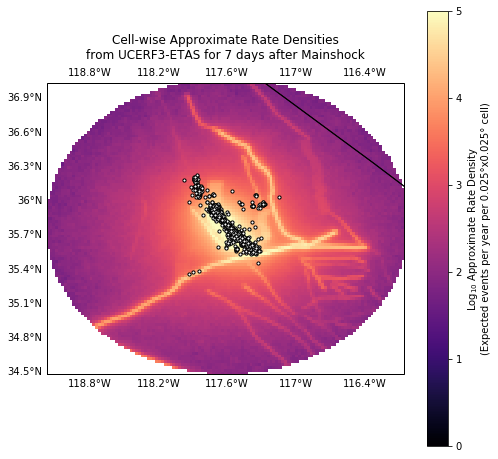

In [83]:
from csep.utils.plotting import plot_spatial_dataset

dh = apprx_rate_density.region.dh
log_crd = np.log10(apprx_rate_density.scale(1.0).spatial_counts(cartesian=True))
ax = plot_spatial_dataset(log_crd, apprx_rate_density.region, 
                          plot_args={
                                'figsize': (8,8),
                                'title': 'Cell-wise Approximate Rate Densities\nfrom UCERF3-ETAS for 7 days after Mainshock',
                                'clabel': r'Log$_{10}$ Approximate Rate Density'
                                           '\n'
                                          f'(Expected events per year per {dh}°x{dh}° cell)',
                                'cmap': 'magma',
                                'clim': [0, 5]})
_ = ax.scatter(comcat.get_longitudes(), comcat.get_latitudes(), marker='.', color='white', s=40, edgecolors='black')

The approximate cell-wise rate densities computed for a UCERF3-ETAS forecast for 7 days immediately following the $M$ 7.1 mainshock of the Ridgecrest sequence. The cell-wise values are the expected number of events per year per 0.25° x 0.25° bin. The effects of the faults in UCERF3-ETAS can be clearly seen by areas with higher approximate rate densities. The events in ComCat are shown with the white circles.

In [100]:
# create forecast object, calling this way reads from hard-drive each time catalogs are iterated through.
u3etas_forecast = CatalogForecast(name='UCERF3-ETAS',
                                  catalogs=u3_catalogs_filt, 
                                  apprx_rate_density=apprx_rate_density, 
                                  filename=os.path.join(u3etas_dir,'results_complete.bin'),
                                  filters=filters, 
                                  filter_spatial=True,
                                  apply_mct=True, 
                                  catalog_format='ucerf3',
                                  region=experiment_configuration['region'], 
                                  origin_epoch=experiment_configuration['origin_epoch'], 
                                  end_epoch=experiment_configuration['end_epoch'], 
                                  magnitudes=experiment_configuration['magnitudes'], 
                                  n_cat=experiment_configuration['number_catalogs'], 
                                  event=experiment_configuration['event'])


# scale to expected rates from density for csep1 evaluation
dh = u3etas_forecast.region.dh
th = u3etas_forecast.time_horizon

# apply csep1 test, simulate catalogs based on poisson assumption, csep1 test uses expected counts not crd
_ = u3etas_forecast.apprx_rate_density.scale(dh*dh*th)
csep1_result = csep1_spatial_test(u3etas_forecast.apprx_rate_density, comcat, num_simulations=1000, verbose=False)

# apply csep2 test, and scale back to original value
csep2_result = csep2_spatial_test(u3etas_forecast, comcat, verbose=False)

# apply csep2 test, and scale back to original value
csep2_cond_nobs_result = csep2_spatial_test(u3etas_forecast, comcat, condition_on_nobs=True, verbose=False,
                                           func=approximate_likelihood_statistic_normalization)

csep2_cond_nobs_mean_result = csep2_spatial_test(u3etas_forecast, comcat, condition_on_nobs=True, verbose=False)

Using catalogs generated by UCERF3-ETAS for evaluation.
Using catalogs generated by UCERF3-ETAS for evaluation.
Using catalogs generated by UCERF3-ETAS for evaluation.


In [104]:
x_csep1, y_csep1 = ecdf(csep1_result.test_distribution - csep1_result.observed_statistic)
x_csep2, y_csep2 = ecdf(csep2_result.test_distribution - csep2_result.observed_statistic)
x_csep2c, y_csep2c = ecdf(csep2_cond_nobs_result.test_distribution - csep2_cond_nobs_result.observed_statistic)
x_csep2cgm, y_csep2cgm = ecdf(csep2_cond_nobs_mean_result.test_distribution - csep2_cond_nobs_mean_result.observed_statistic)

print(f'Quantile Score (CSEP1): {csep1_result.quantile}\n'
      f'Quantile Score (CSEP2): {csep2_result.quantile}\n'
      f'Quantile Score (LL | Nobs): {csep2_cond_nobs_result.quantile}\n'
      f'Quantile Score (GeoMean | Nobs): {csep2_cond_nobs_mean_result.quantile}')
print()

print(f'Observed Statistic (CSEP1): {csep1_result.observed_statistic}\n'
      f'Observed Statistic (CSEP2): {csep2_result.observed_statistic}\n'
      f'Observed Statistic (LL | Nobs): {csep2_cond_nobs_result.observed_statistic}\n'
      f'Observed Statistic (GeoMean | Nobs): {csep2_cond_nobs_mean_result.observed_statistic}')
print()

print(f'Observed Statistic (CSEP1): {csep1_result.observed_statistic}\n'
      f'Observed Statistic (CSEP2): {csep2_result.observed_statistic}\n'
      f'Observed Statistic (LL | Nobs): {csep2_cond_nobs_result.observed_statistic}\n'
      f'Observed Statistic (GeoMean | Nobs): {csep2_cond_nobs_mean_result.observed_statistic}')

Quantile Score (CSEP1): 0.0
Quantile Score (CSEP2): 0.09641
Quantile Score (LL | Nobs): 0.00105
Quantile Score (GeoMean | Nobs): 0.00037

Observed Statistic (CSEP1): -1896.1999073296597
Observed Statistic (CSEP2): -2.4052266328186356
Observed Statistic (LL | Nobs): -3324.0232065553546
Observed Statistic (GeoMean | Nobs): -2.4052266328186356

Observed Statistic (CSEP1): -1896.1999073296597
Observed Statistic (CSEP2): -2.4052266328186356
Observed Statistic (LL | Nobs): -3324.0232065553546
Observed Statistic (GeoMean | Nobs): -2.4052266328186356


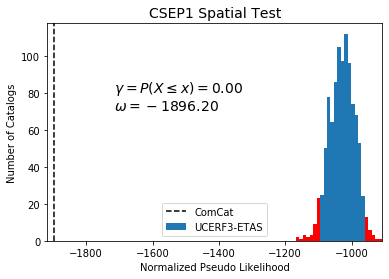

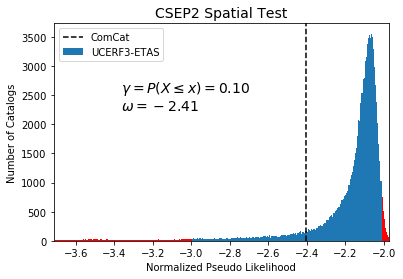

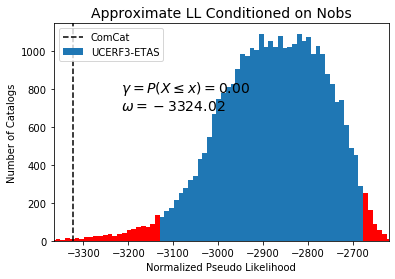

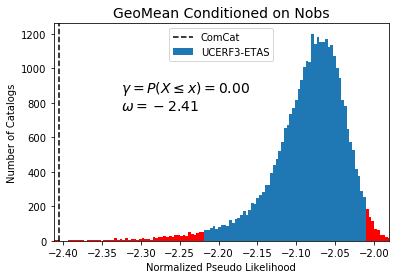

In [106]:
from csep.utils.plotting import plot_consistency_test, plot_spatial_test

csep1_result.sim_name = 'UCERF3-ETAS'
ax = plot_spatial_test(csep1_result, plot_args={"title":"CSEP1 Spatial Test"})

csep2_result.obs_name = 'ComCat'
ax = plot_spatial_test(csep2_result)

csep2_cond_nobs_result.obs_name = 'ComCat'
ax = plot_spatial_test(csep2_cond_nobs_result, plot_args={'title': 'Approximate LL Conditioned on Nobs'})

csep2_cond_nobs_mean_result.obs_name = 'ComCat'
ax = plot_spatial_test(csep2_cond_nobs_mean_result, plot_args={'title': 'GeoMean Conditioned on Nobs'})

These figures re-create the analysis from the SU forecasts and apply it to the first forecast made during the Ridgecrest sequence. The top figure shows the CSEP1 result based on assumptions of independent Poisson behavior in space-time cells. The bottom three figures show different implementations based on simulations produced by the UCERF3-ETAS. 

The figure second from the top shows the currently proposed Spatial Test metric. The bottom two figures show the statistics where only the catalogs within a 10% tolerance of $N_{obs}$ are used as simulations. This results as shown might be inconsistent because the expected cell-wise rates were also not conditioned on the number of observed events.

### Correlation between the Geo. Mean statistic and Number Distribution

In [132]:
event_counts = [cat.event_count for cat in u3_catalogs_filt]
test_distribution = csep2_result.test_distribution

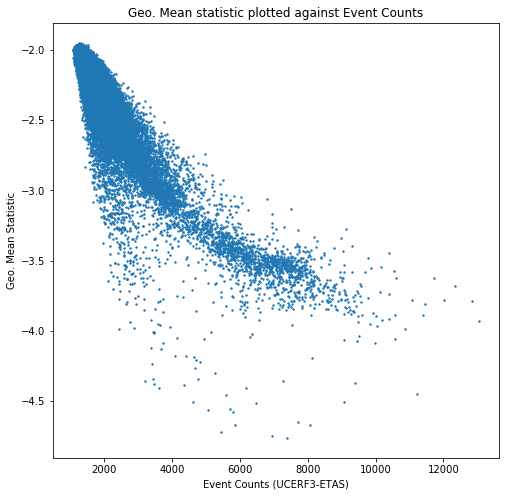

In [135]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(event_counts, test_distribution, s=2)
_ = ax.set_title("Geo. Mean statistic plotted against Event Counts")
_ = ax.set_xlabel("Event Counts (UCERF3-ETAS)")
_ = ax.set_ylabel("Geo. Mean Statistic")

### Cell-wise Approximate Likelihood Ratios between U3ETAS and U3NoFaults

[To be completed]

### Spatial Occurrence Probability

[To be completed]

In [113]:
from csep.core.analysis import SpatialProbabilityTest

def spatial_probability_test(catalogs_iterable, observed_catalog, experiment_config, 
                             filter_forecast=True, verbose=False, filter_catalogs=False):
    """ Compute the approximate rate density from a catalog-based forecast
    
    Args:
        catalogs_iterable (iterable): collection of catalogs, should be filtered outside the function
        observed_catalog (csep.core.AbstractBaseCatalog): observation catalog
        
    Return:
        output (GriddedDataSet): approximate_rate_density
    """
    task = SpatialProbabilityTest()
    task.mws = [2.5]
    
    t0 = time.time()
    for i, cat in enumerate(catalogs_iterable):
        # filter in time, filter spatial extent, and apply mc(t)
        if filter_catalogs:
            cat = cat.filter(f"origin_time < {experiment_config['end_epoch']}") \
                          .filter(f"magnitude >= {experiment_config['minimum_mw']}") \
                          .filter_spatial(experiment_config['region']) \
                          .apply_mct(experiment_config['event_mw'], experiment_config['event_epoch'])
        
        # compute spatial density from each catalog
        task.process(cat)
        
        # output status
        if verbose:
            tens_exp = np.floor(np.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i+1} catalogs in {t1-t0} seconds', flush=True)
    
    # need to process again to actually build the test distribution
    for i, cat in enumerate(catalogs_iterable):
        # filter in time, filter spatial extent, and apply mc(t)
        if filter_catalogs:
            cat = cat.filter(f"origin_time < {experiment_config['end_epoch']}") \
                          .filter(f"magnitude >= {experiment_config['minimum_mw']}") \
                          .filter_spatial(experiment_config['region']) \
                          .apply_mct(experiment_config['event_mw'], experiment_config['event_epoch'])
        
        # compute spatial density from each catalog
        task.process_again(cat, args=(experiment_config['time_horizon'], 
                                      experiment_config['number_catalogs'],
                                      experiment_config['end_epoch'],
                                      observed_catalog))
        
        # output status
        if verbose:
            tens_exp = np.floor(np.log10(i + 1))
            if (i + 1) % 10 ** tens_exp == 0:
                t1 = time.time()
                print(f'Processed {i+1} catalogs in {t1-t0} seconds', flush=True)
                
    # compute rate density
    result = task.post_process(observed_catalog,
                               args=(experiment_config['time_horizon'],
                                     time_horizon, None, experiment_config['number_catalogs']))
        
    # maybe we need to apply some type of gaussian smoothing if undersampled
    cnt_zero = np.count_nonzero(task.data==0)
    if cnt_zero > 0:
        print(f"Probability map undersampled: found {cnt_zero} undersampled bins.\n"
               "Applying nearest-neighbor interpolation to fill in missing values.")
        data = fill(task.data, task.data == 0)
    else:
        data = task.data
        
    # create gridded data set
    n_cat = experiment_config['number_catalogs']
    prob_map = data / n_cat
    spatial_output = GriddedDataSet(data=prob_map, region=experiment_config['region'])
    return (spatial_output, result)

In [112]:
prob_map, prob_test_result = spatial_probability_test(u3_catalogs_filt, comcat, experiment_configuration, verbose=True)

Processed 1 catalogs in 0.01918768882751465 seconds
Processed 2 catalogs in 0.03136157989501953 seconds
Processed 3 catalogs in 0.0444028377532959 seconds
Processed 4 catalogs in 0.057073116302490234 seconds
Processed 5 catalogs in 0.06333422660827637 seconds
Processed 6 catalogs in 0.08643341064453125 seconds
Processed 7 catalogs in 0.10208415985107422 seconds
Processed 8 catalogs in 0.10852527618408203 seconds
Processed 9 catalogs in 0.1305983066558838 seconds
Processed 10 catalogs in 0.1468343734741211 seconds
Processed 20 catalogs in 0.21858906745910645 seconds
Processed 30 catalogs in 0.2887237071990967 seconds
Processed 40 catalogs in 0.3600442409515381 seconds
Processed 50 catalogs in 0.45456767082214355 seconds
Processed 60 catalogs in 0.5145494937896729 seconds
Processed 70 catalogs in 0.5835957527160645 seconds
Processed 80 catalogs in 0.6647388935089111 seconds
Processed 90 catalogs in 0.7133774757385254 seconds
Processed 100 catalogs in 0.7981927394866943 seconds
Processed 

/home/scec-01/wsavran/git/csep2/csep/core/analysis.py:1434: RuntimeWarning: divide by zero encountered in log10
  prob_map = numpy.log10(self.data / n_cat)


Processed 20 catalogs in 496.97738575935364 seconds
Processed 30 catalogs in 497.11060214042664 seconds
Processed 40 catalogs in 497.2238655090332 seconds
Processed 50 catalogs in 497.33684372901917 seconds
Processed 60 catalogs in 497.40835881233215 seconds
Processed 70 catalogs in 497.49328422546387 seconds
Processed 80 catalogs in 497.5525267124176 seconds
Processed 90 catalogs in 497.60568499565125 seconds
Processed 100 catalogs in 497.65929079055786 seconds
Processed 200 catalogs in 498.3630795478821 seconds
Processed 300 catalogs in 498.96413683891296 seconds
Processed 400 catalogs in 499.7243175506592 seconds
Processed 500 catalogs in 500.33781361579895 seconds
Processed 600 catalogs in 500.9543695449829 seconds
Processed 700 catalogs in 501.5347225666046 seconds
Processed 800 catalogs in 502.2314896583557 seconds
Processed 900 catalogs in 502.91222977638245 seconds
Processed 1000 catalogs in 503.5816786289215 seconds
Processed 2000 catalogs in 510.05360078811646 seconds
Process

/home/scec-01/wsavran/git/csep2/csep/core/analysis.py:1448: RuntimeWarning: divide by zero encountered in log10
  prob_map = numpy.log10(self.data / n_cat)


Approximate Rate Density undersampled: found 41 undersampled bins.
Applying nearest-neighbor interpolation to fill in missing values.


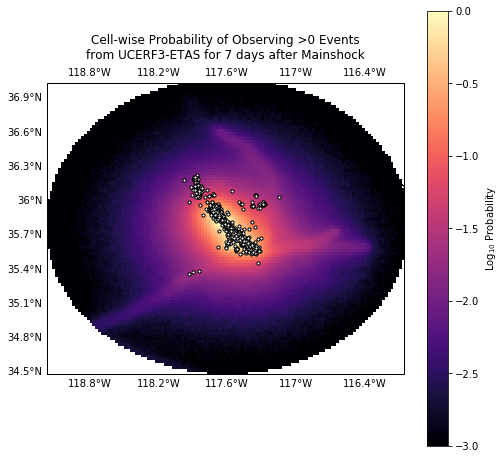

In [126]:
log_prob = prob_map.data[0,:]
ax = plot_spatial_dataset(np.log10(prob_map.region.get_cartesian(log_prob)), prob_map.region, 
                          plot_args={
                                'figsize': (8,8),
                                'title': 'Cell-wise Probability of Observing >0 Events\nfrom UCERF3-ETAS for 7 days after Mainshock',
                                'clabel': r'Log$_{10}$ Probability',
                                'cmap': 'magma',
                                'clim': [-3, 0]})
_ = ax.scatter(comcat.get_longitudes(), comcat.get_latitudes(), marker='.', color='white', s=40, edgecolors='black')

The probability map is defined as the cell-wise probability of observing 1 or more events during the forecast time-horizon. This test implicitly assumes that each cell is a random variable and reverts back to the assumptions of independence to compute a joint log-likelihood for the entire forecast. 

To compute the test statistic for the spatial probability test, we first compute the spatial probabilty map by counting. Mathematically, we can define this using an indicator function in each cell [notation needs work], 

\begin{equation*}
1_k(e) = \left\{
        \begin{array}{ll}
            1 & \text{if} \, \text{any}(e) \in k \\
            0 & \text{if} \, \text{any}(e) \notin k
        \end{array}
    \right.
\end{equation*}

where, $k$, represents a discretized spatial cell. We then stack these binary maps for each simulation from the forecast by,

\begin{equation}
p(k) = \left ( \sum_{i=1}^{N_{sim}} 1_k(e_i) \right ) N_{sim}^{-1}
\end{equation}

Here, $p(k)$ is a vector that contains in each discrete cell the fraction of simulations where one or more events occured.  We can interpret this value as a cell-wise probability and compute a test statistic following,

\begin{equation}
\gamma_s = \sum_k 1_k(e_{t}) \log p(k)
\end{equation}

where $k_i$, denotes the cell where a target event occurs, $1_k(e_{t})$ is the binary event occurence map computed for a target catalog.

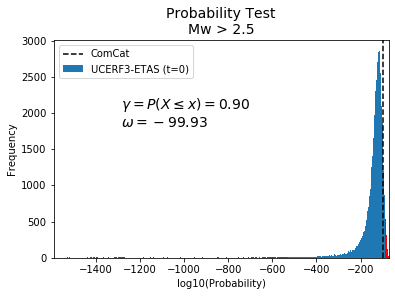

In [130]:
from csep.utils.plotting import plot_probability_test

plot_args = {'percentile': 95,
                         'title': f'Probability Test\nMw > {2.5}',
                         'bins': 'auto',
                         'xlabel': 'log10(Probability)'}
_ = plot_probability_test(prob_test_result[2.5], plot_args=plot_args)

## Fault-based Ruptures in U3ETAS

[To be completed]

# New Cramer von-Mises statistic for Comparing Histograms (Incremental MFDs) and Comparisons with Old Metrics Including CSEP1

In this section, I explore the behavior of the current CSEP2 implementation and two other non-parameteric alternatives that do not include logarithms. I also evaluate the performance of the CSEP1 Poisson likelihood-based metrics.

The experiment is simple, and mimics a real work situation including GR MFDs and ETAS-like number distributions. Fundamentally, the test is designed to understand two things: (1) whether the test is properly calibrated (?; whether a family of quantile scores from independent trials form a uniform distribution) and (2) the sensitivity of the test results to differences in b-value between the forecast and observations.

I include four different test statistics in this analysis (math notation should be here, but words and code shall suffice):
1. Square-metric of log10(bin-counts) differences
2. Square-metric of bin-counts differences
3. Cramer von-Mises statistic
4. CSEP1 Poisson likelihood implementation

The test statistic for a two-sample Cramer von-Mises test for histograms with bin contents $u_1, u_2, \ldots, u_k$ and $v_1, v_2, \ldots, v_k$ can be written,

\begin{equation}
T = \frac{N_u N_v}{(N_u + N_v)^2} \sum_{j=1}^k (u_j+v_j)[E_u(z_j)-E_v(z_j)]^2.
\end{equation}

Let $z$ be a point in bin $i$ and $E_u(z) = \sum_{j=1}^i u_i/N_u$.

(An idea...)

## Understanding Mag. Test based on Square Metric of Log10 counts

The analysis below investiates the behavior of the proposed Mag. Test by looking at uniform histograms and those originating from Gutenberg Richter distributions.

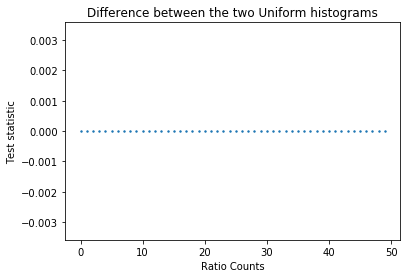

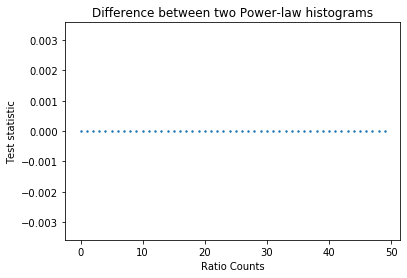

In [357]:
def currently_proposed_magnitude_statistic(hist1, hist2):
    """ hist1 and hist2 are histogram that can have different numbers of counts. """
    n_hist1 = np.sum(hist1)
    n_hist2 = np.sum(hist2)
    d = np.sum((np.log10(n_hist2 / n_hist1 * hist1 + 1) - np.log10(n_hist2 / n_hist2 * hist2 + 1))**2)
    return d

def currently_proposed_magnitude_statistic_no_log(hist1, hist2):
    """ hist1 and hist2 are histogram that can have different numbers of counts. """
    n_hist1 = np.sum(hist1)
    n_hist2 = np.sum(hist2)
    d = np.sum((n_hist2 / n_hist1 * hist1 - n_hist2 / n_hist2 * hist2)**2)
    return d

def cramer_von_mises(hist1, hist2):
    n_obs1 = np.sum(hist1)
    n_obs2 = np.sum(hist2)
    cum_hist1 = np.cumsum(hist1) / n_obs1
    cum_hist2 = np.cumsum(hist2) / n_obs2
    t = (n_obs1*n_obs2)/(n_obs1+n_obs2)**2 * np.sum((hist1+hist2)*(cum_hist1-cum_hist2)**2)
    return t

n_bins = 100
n_tests = 50
uni_histA = np.ones(n_bins)
uni_histB = np.ones((n_bins,n_tests))*np.arange(1,n_tests+1)

test_output = []
for i in range(n_tests):
    test_output.append(currently_proposed_magnitude_statistic(uni_histA, uni_histB[:,0]))
    
fig, ax = plt.subplots()
_ = ax.scatter(np.arange(n_tests), test_output, s=2)
_ = ax.set_title("Difference between the two Uniform histograms")
_ = ax.set_xlabel("Ratio Counts")
_ = ax.set_ylabel("Test statistic")

# create incremental magnitude number distributions where each bin has 10x the number
def get_power_hist(mult):
    return mult * 10**(np.arange(n_bins)*0.025)[::-1]

second_test = []
main_hist = get_power_hist(1)
for i in range(1,n_tests+1):
    test_hist = get_power_hist(i)
    second_test.append(currently_proposed_magnitude_statistic(main_hist, test_hist))

fig, ax = plt.subplots()
_ = ax.scatter(np.arange(n_tests), test_output, s=2)
_ = ax.set_title("Difference between two Power-law histograms")
_ = ax.set_xlabel("Ratio Counts")
_ = ax.set_ylabel("Test statistic")

In [358]:
from scipy import interpolate 
from csep.utils.constants import CSEP_MW_BINS
from csep.utils.calc import bin1d_vec
from csep.core.evaluations import EvaluationResult
from csep.utils.stats import get_quantiles
from csep.utils.plotting import plot_magnitude_test

def sample_gr_cdf(size, bval=1.0, mc=2.5, mmax=9.0, dm=0.1):
    m = np.arange(mc, mmax, dm)
    beta = np.log(10)*bval
    cdf = 1 - np.exp(-beta*(m-mc))
    inv_cdf = interpolate.interp1d(cdf, m)
    # this is bc this method is q&d
    while True:
        try:
            vals = inv_cdf(np.random.rand(size))
            break
        except ValueError:
            continue          
    return vals

def quick_hist(data, bins=CSEP_MW_BINS):
    idx = bin1d_vec(data, CSEP_MW_BINS, right_continuous=True)
    out = np.zeros(len(bins))
    np.add.at(out,idx,1)
    return (bins, out)

n_sim = 1000

# use ucerf3-etas number distribution
sampled_u3etas_ncat = np.random.choice(event_counts, size=n_sim)

# driver for the magnitude test simulator
def simulate_magnitude_test(number_dist, bval=1.0, true_bval=1.0,  
                            func=currently_proposed_magnitude_statistic): 
    ex_count = int(np.mean(sampled_u3etas_ncat))
    bins, true_gr_hist = quick_hist(sample_gr_cdf(ex_count, bval=true_bval))
    test_hists = []
    for i in range(len(number_dist)):
        event_count = number_dist[i]
        _, test_hist = quick_hist(sample_gr_cdf(event_count, bval=bval))
        test_hists.append(test_hist)

    # compute expected hist
    exp_hist = np.sum(np.array(test_hists), axis=0) / n_sim
    
    # compute test statistics
    test_stats = []
    true_stat = func(exp_hist, true_gr_hist)
    for h in test_hists:
        test_stats.append(func(exp_hist, h))
    _, quantile = get_quantiles(test_stats, true_stat)

    # put into evaluation result for plotting
    res = EvaluationResult()
    res.test_distribution = test_stats
    res.observed_statistic = true_stat
    res.obs_name = 'observed'
    res.sim_name = 'simulated'
    res.quantile = quantile
    
    return res, true_gr_hist, exp_hist

## Current Implementation of M-Test

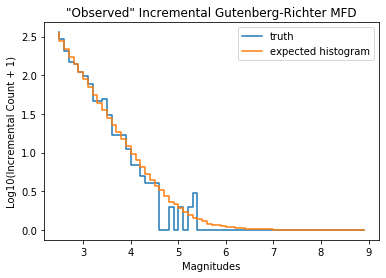

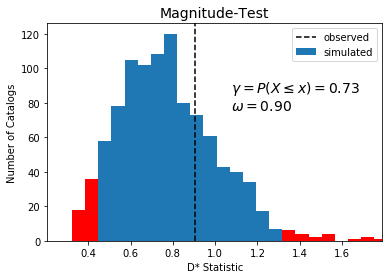

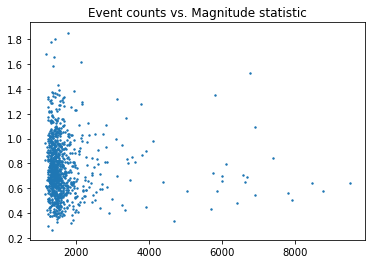

In [359]:
res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat)

fig, ax = plt.subplots()
_ = ax.step(bins, np.log10(true_hist_bv1+1), label='truth')
_ = ax.step(bins, np.log10(exp_hist_bv1+1), label='expected histogram')
_ = ax.set_title('"Observed" Incremental Gutenberg-Richter MFD')
_ = ax.set_xlabel("Magnitudes")
_ = ax.set_ylabel("Log10(Incremental Count + 1)")
_ = ax.legend(loc='upper right')

plot_args = {'percentile': 95,
             'title': f'Magnitude-Test',
             'bins': 'auto'}
_ = plot_magnitude_test(res_bv1, plot_args=plot_args)

fig, ax = plt.subplots()
_ = ax.scatter(sampled_u3etas_ncat, test_stats, s=2)
_ = ax.set_title("Event counts vs. Magnitude statistic")

## Cramer von-Mises statistic

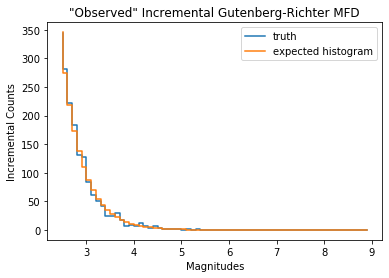

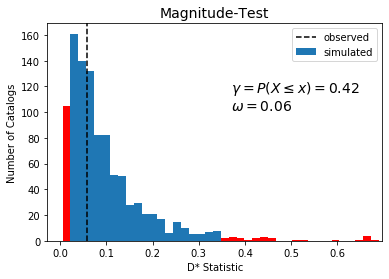

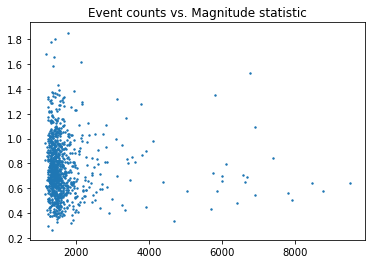

In [360]:
res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat, bval=1, func=cramer_von_mises)

fig, ax = plt.subplots()
_ = ax.step(bins, true_hist_bv1, label='truth')
_ = ax.step(bins, exp_hist_bv1, label='expected histogram')
_ = ax.set_title('"Observed" Incremental Gutenberg-Richter MFD')
_ = ax.set_xlabel("Magnitudes")
_ = ax.set_ylabel("Incremental Counts")
_ = ax.legend(loc='upper right')

plot_args = {'percentile': 95,
             'title': f'Magnitude-Test',
             'bins': 'auto'}
_ = plot_magnitude_test(res_bv1, plot_args=plot_args)

fig, ax = plt.subplots()
_ = ax.scatter(sampled_u3etas_ncat, test_stats, s=2)
_ = ax.set_title("Event counts vs. Magnitude statistic")

## Square Metric with No-Logarithm

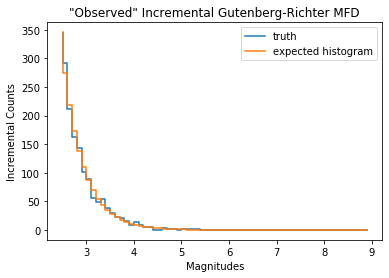

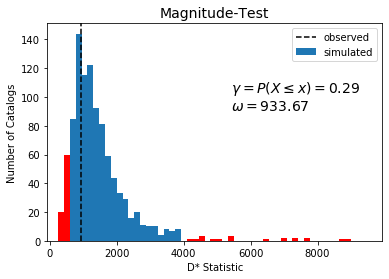

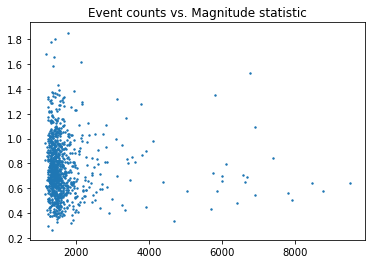

In [361]:
res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat, bval=1, func=currently_proposed_magnitude_statistic_no_log)

fig, ax = plt.subplots()
_ = ax.step(bins, true_hist_bv1, label='truth')
_ = ax.step(bins, exp_hist_bv1, label='expected histogram')
_ = ax.set_title('"Observed" Incremental Gutenberg-Richter MFD')
_ = ax.set_xlabel("Magnitudes")
_ = ax.set_ylabel("Incremental Counts")
_ = ax.legend(loc='upper right')

plot_args = {'percentile': 95,
             'title': f'Magnitude-Test',
             'bins': 'auto'}
_ = plot_magnitude_test(res_bv1, plot_args=plot_args)

fig, ax = plt.subplots()
_ = ax.scatter(sampled_u3etas_ncat, test_stats, s=2)
_ = ax.set_title("Event counts vs. Magnitude statistic")

## Calibration Tests for Catalog-based Metrics

This section shows the calibration tests for the three catalog-based metrics. The main take-away is that both the Cramer von-Mises and the Square-Metric using Logs are calibrated while the Square-metric without logs seems to be under-dispersed.

In this test, both the 'forecast' and 'observation' assume $b=1.0$ for the 'truth' and forecasts.

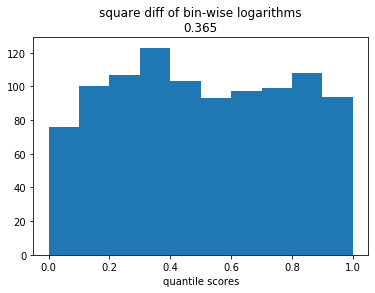

In [362]:
n_tests = 1000
test_results = []
for i in range(n_tests):
    res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat)
    test_results.append(res_bv1.quantile)
fig, ax = plt.subplots()
_ = ax.hist(test_results, bins=10)
_, pv = kstest(test_results, 'uniform')
_ = ax.set_title(f"square diff of bin-wise logarithms\n{pv:.3}")
_ = ax.set_xlabel('quantile scores')

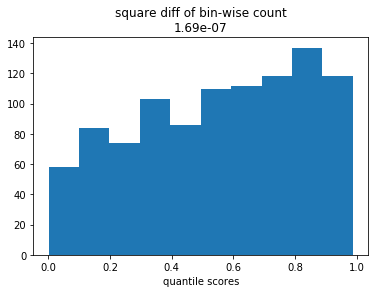

In [363]:
n_tests = 1000
test_results = []
for i in range(n_tests):
    res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat, 
                                                                   func=currently_proposed_magnitude_statistic_no_log)
    test_results.append(res_bv1.quantile)
fig, ax = plt.subplots()
_ = ax.hist(test_results, bins=10)
_, pv = kstest(test_results, 'uniform')
_ = ax.set_title(f"square diff of bin-wise count\n{pv:.3}")
_ = ax.set_xlabel('quantile scores')

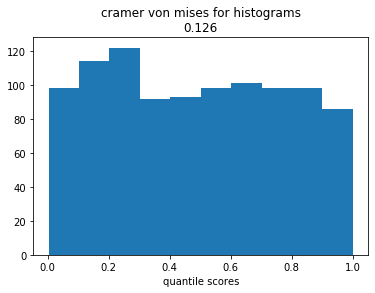

In [364]:
n_tests = 1000
test_results = []
for i in range(n_tests):
    res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat, func=cramer_von_mises)
    test_results.append(res_bv1.quantile)
fig, ax = plt.subplots()
_, pv = kstest(test_results, 'uniform')
_ = ax.hist(test_results, bins=10)
_ = ax.set_title(f"cramer von mises for histograms\n{pv:.3}")
_ = ax.set_xlabel('quantile scores')

## Behavior of Tests for MFDs containing different b-values

Here, we assume that the observed MFD has a b-value in the range of $[0.6 - 1.6]$ while the simulated catalogs always use $b = 1$. To visualize the behavior of these tests, we plot the p-value of a KS test for uniformity of the family of quantiles scores generated from each of the different metrics.

This test tries to understand how sensitive each of these tests are to changes in b-value using a realistic number distribution from an ETAS forecast.

In [366]:
from scipy.stats import kstest
from collections import defaultdict

class FuncRunner:
    def __init__(self, func, name):
        self.func = func
        self.name = name
        
cvm = FuncRunner(cramer_von_mises, 'Cramer von-Mises')
cp_log = FuncRunner(currently_proposed_magnitude_statistic, 'Square-metric w/ log')
cp_nolog = FuncRunner(currently_proposed_magnitude_statistic_no_log, 'Square-metric no log')

# experiment config
n_tests = 500
bvals = np.arange(0.6,1.61,0.2)
funcs = [cvm, cp_log, cp_nolog]

# runner
r = defaultdict(dict)
for bv in bvals:
    for func in funcs:
        print(f"bv: {bv:.2} w/ func: {func.name}")
        test_results = []
        for i in range(n_tests):
            res_bv1, true_hist_bv1, exp_hist_bv1 = simulate_magnitude_test(sampled_u3etas_ncat, func=func.func, true_bval=bv)
            test_results.append(res_bv1.quantile)
        # only store the quantile scores
        r[func.name][bv] = test_results

bv: 0.6 w/ func: Cramer von-Mises
bv: 0.6 w/ func: Square-metric w/ log
bv: 0.6 w/ func: Square-metric no log
bv: 0.8 w/ func: Cramer von-Mises
bv: 0.8 w/ func: Square-metric w/ log
bv: 0.8 w/ func: Square-metric no log
bv: 1.0 w/ func: Cramer von-Mises
bv: 1.0 w/ func: Square-metric w/ log
bv: 1.0 w/ func: Square-metric no log
bv: 1.2 w/ func: Cramer von-Mises
bv: 1.2 w/ func: Square-metric w/ log
bv: 1.2 w/ func: Square-metric no log
bv: 1.4 w/ func: Cramer von-Mises
bv: 1.4 w/ func: Square-metric w/ log
bv: 1.4 w/ func: Square-metric no log
bv: 1.6 w/ func: Cramer von-Mises
bv: 1.6 w/ func: Square-metric w/ log
bv: 1.6 w/ func: Square-metric no log


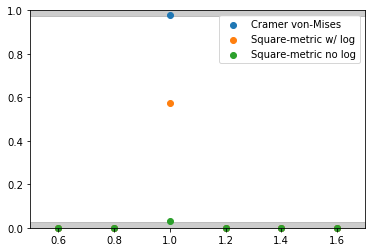

In [394]:
# compute k-s tests between uniform distribution and each of the tests and make scatter plot
from matplotlib import transforms

ks_bv_results = defaultdict(list)
for func_name, func_results_dict in r.items():
    for b_value, b_value_result in func_results_dict.items():
        _, p_value = kstest(b_value_result, 'uniform')
        ks_bv_results[func_name].append((b_value, p_value))

fig, ax = plt.subplots()
trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.fill_between((0,1), 0.025, color='gray', transform=trans, alpha=0.4)
ax.fill_between((0,1), 0.975, y2=1.0, color='gray', transform=trans, alpha=0.4)
ax.set_xlim([0.5,1.7])
ax.set_ylim([0,1])
for func_name, res in ks_bv_results.items():
    res = np.array(res)
    ax.scatter(res[:,0], res[:,1], label=func_name, clip_on=False)
_ = ax.legend(loc='upper right')


### More extensive Calibration Study

These plots just use more simulations to understand better the behavior for these tests. In this test, both the 'forecast' and 'observation' assume $b=1.0$ for the 'truth' and forecasts.

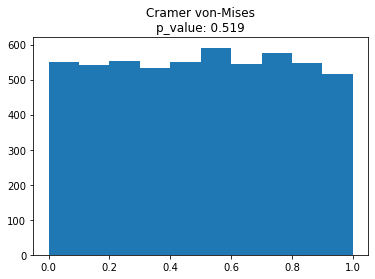

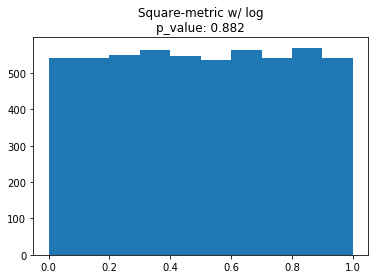

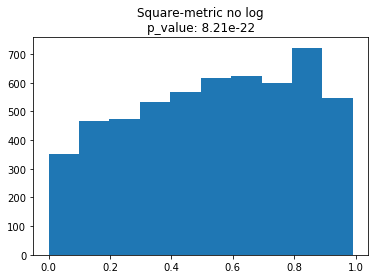

In [356]:
# note: these plots were created by accident, but they are valid. in the first calculation of the above tests,
# i did not actually vary the b-value, so therefore these tests are for b_true=1.0 and b_fore=1.0. The results 
# are valid nonetheless.

# aggregate results
for func_name, test_dist in ks_results.items():
    fig, ax = plt.subplots()
    ax.hist(test_dist, bins=10)
    _, p_value = kstest(test_dist, 'uniform')
    ax.set_title(f"{func_name}\np_value: {p_value:.3}")

In [ ]:
# comparison with csep1 test
from csep.core.csep1_tests import csep1_magnitude_test

class MockForecast:
    def __init__(self, data):
        self.data = data
        self.name = 'Test Forecast'
        self.magnitudes = CSEP_MW_BINS
        
    def magnitude_counts(self):
        return self.data
    
class MockCatalog:
    def __init__(self, data):
        self.name = 'Test Observation'
        self.data = data
        
    def magnitude_counts(self, bins=()):
        return self.data

def csep1_magnitude_test_runner(number_dist, bval):
    # in csep1 we'd assume that the smooth mfd would be the one produced by the forecast
    test_hists = []
    exp_count = int(np.mean(number_dist))
    for i in range(len(number_dist)):
        event_count = int(number_dist[i])
        _, test_hist = quick_hist(sample_gr_cdf(event_count, bval=1.0))
        test_hists.append(test_hist)

    # compute expected hist
    exp_hist = np.sum(np.array(test_hists), axis=0) / n_sim

    # arbitrary choice of events
    _, god_hist = quick_hist(sample_gr_cdf(exp_count, bval=bval))

    _ = ax.step(bins, exp_hist, label="'Forecast'")
    _ = ax.step(bins, god_hist, label="'Observation'")
    _ = ax.legend(loc='best')

    # just adding 1 because of log(rates) in csep1 test
    catalog = MockCatalog(god_hist)
    forecast = MockForecast(exp_hist)

    result = csep1_magnitude_test(forecast, catalog, verbose=False)
    return result

n_tests = 500
csep1_res_mtest = defaultdict(list)
bvals = np.arange(0.6,1.61,0.2)
for bv in bvals:
    print(f'{bv:.2}')
    for i in range(n_tests):
        res = csep1_magnitude_test_runner(sampled_u3etas_ncat, bv)
        csep1_res_mtest[bv].append(res.quantile)

## References

Rhoades, D. A., D. Schorlemmer, M. C. Gerstenberger, A. Christophersen, J. D. Zechar, and M. Imoto (2011). Efficient testing of earthquake forecasting models, Acta Geophys 59 728-747.

Savran, W., M. J. Werner, W. Marzocchi, D. Rhoades, D. D. Jackson, K. R. Milner, E. H. Field, and A. J. Michael (In Prep.). Pseudo-prospective evaluation of UCERF3-ETAS forecasts during the 2019 Ridgecrest Sequence, Bulletin of the Seismological Society of America.

Zechar, J. D., M. C. Gerstenberger, and D. A. Rhoades (2010). Likelihood-Based Tests for Evaluating Space-Rate-Magnitude Earthquake Forecasts, Bulletin of the Seismological Society of America 100 1184-1195.